# Delivery Time with Multivariable Linear Regression


In [2]:
from math import radians, sin, cos, asin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline

In [3]:
orders    = pd.read_csv('olist_orders_dataset.csv')
items     = pd.read_csv('olist_order_items_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
sellers   = pd.read_csv('olist_sellers_dataset.csv')
geo       = pd.read_csv('olist_geolocation_dataset.csv')
products  = pd.read_csv('olist_products_dataset.csv')

In [4]:
# Get seller zip code of each order
# [order_id, seller_id]
#
orderIdSellerId = items[['order_id', 'seller_id']]

# [order_id, seller_id, seller_zip_code_prefix]
#
orderIdSellerIdWithZip = orderIdSellerId.merge(sellers[['seller_id', 'seller_zip_code_prefix']], on = "seller_id", how = "outer")

# [order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at,
#  order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date,
#  seller_id, seller_zip_code_prefix]
#
orders = orders.merge(orderIdSellerIdWithZip, on = 'order_id', how = 'left')

# Get customer zip code of each order
#
# [order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at,
#  order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date,
#  seller_id, seller_zip_code_prefix, customer_zip_code_prefix]
#
orders = orders.merge(customers[['customer_id', 'customer_zip_code_prefix']], on = 'customer_id', how = 'left')

# Clean geo duplicates
#
geo = geo[~geo['geolocation_zip_code_prefix'].duplicated()]

# Add seller coordinates to the orders
#
# [order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at,
#  order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date,
#  seller_id, seller_zip_code_prefix, customer_zip_code_prefix, geolocation_zip_code_prefix,
#  geolocation_lat, geolocation_lng, geolocation_city, geolocation_state]
#
orders = orders.merge(geo, left_on = 'seller_zip_code_prefix', right_on = 'geolocation_zip_code_prefix', how = 'left')

# Add customer coordinates to the orders
#
# [order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at,
#  order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date,
#  seller_id, seller_zip_code_prefix, customer_zip_code_prefix, geolocation_zip_code_prefix_seller,
#  geolocation_lat_seller, geolocation_lng_seller, geolocation_city_seller, geolocation_state_seller,
#  geolocation_zip_code_prefix_customer, geolocation_lat_customer, geolocation_lng_customer,
#  geolocation_city_customer, geolocation_state_customer]
#
orders = orders.merge(geo, left_on = 'customer_zip_code_prefix', right_on = 'geolocation_zip_code_prefix', how = "left",
                      suffixes = ('_seller', '_customer'))

In [5]:
# Remove orders with multiple sellers
#
df = orders.groupby(by="order_id").nunique()
mono_orders = pd.Series(df[df['seller_id'] == 1].index)
filtered_orders = orders.merge(mono_orders, how = 'inner')

print(orders.shape)
print(filtered_orders.shape)

# Remove column order_approved_at and rows with missing values
#
filtered_orders = filtered_orders.drop(columns = ["order_approved_at"])
filtered_orders = filtered_orders.dropna()

print(filtered_orders.shape)

(113425, 21)
(109547, 21)
(106578, 20)


### Distance of Delivery (angular distance)

In [6]:
# Compute the angular distance between two points on a sphere 
# given their longitudes and latitudes
#
def haversine_distance(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * 6371 * asin(sqrt(a))

# Add computed distances column to dataset
#
filtered_orders['distance'] = filtered_orders.apply(
    lambda row: haversine_distance(
        row['geolocation_lng_seller'],
        row['geolocation_lat_seller'],
        row['geolocation_lng_customer'],
        row['geolocation_lat_customer'],
    ),
    axis=1,
)

### Package size ($cm^3$) and weight ($g$)

In [7]:
df_tmp = items[['order_id', 'product_id']].merge(products[['product_id', 'product_length_cm', 
                                                           'product_height_cm', 'product_width_cm', 'product_weight_g']],
                                                            on = "product_id", how = "outer")

df_tmp.loc[:, "product_size_cm3"] = df_tmp['product_length_cm'] * df_tmp['product_width_cm'] * df_tmp['product_height_cm']

orders_size_weight = df_tmp.groupby("order_id", as_index = False).sum()[['order_id','product_size_cm3', 'product_weight_g']]

# Add computed package size and weight column to dataset
#
filtered_orders = filtered_orders.merge(orders_size_weight, on = 'order_id', how = 'left')

### Delivery time (days) - our target

In [8]:
# Convert time columns
#
time_columns = ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']

for column in time_columns:
    filtered_orders.loc[:, column] = pd.to_datetime(filtered_orders[column])

# Add computed delivery time to dataset
#    
filtered_orders.loc[:,"wait_time"] = (filtered_orders['order_delivered_customer_date'] - 
                                      filtered_orders['order_purchase_timestamp']).dt.days

In [9]:
# show table in a transposed way
#
filtered_orders.T

,0,1,2,3,4,5,6,7,8,9,...,106568,106569,106570,106571,106572,106573,106574,106575,106576,106577
order_id,e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d,949d5b44dbf5de918fe9c16f97b45f8a,ad21c59c0840e6cb83a9ceb5573f8159,a4591c265e18cb1dcee52889e2d8acc3,6514b8ad8028c9f2cc2374ded245783f,76c6e866289321a7c93b82b54852dc33,e69bfb5eb88e0ed6a785585b27e16dbf,e6ce16cb79ec1d90b1da9085a6118aeb,...,9115830be804184b91f5c00f6f49f92d,9115830be804184b91f5c00f6f49f92d,aa04ef5214580b06b10e2a378300db44,880675dff2150932f1601e1c07eadeeb,9c5dedf39a927c1b2549525ed64a053c,63943bddc261676b46f01ca7ac2f7bd8,83c1379a015df1e13d02aae0204711ab,11c177c8e97725db2631073c19f07b62,11c177c8e97725db2631073c19f07b62,66dea50a8b16d9b4dee7af250b4be1a5
customer_id,9ef432eb6251297304e76186b10a928d,b0830fb4747a6c6d20dea0b8c802d7ef,41ce2a54c0b03bf3443c3d931a367089,f88197465ea7920adcdbec7375364d82,8ab97904e6daea8866dbdbc4fb7aad2c,503740e9ca751ccdda7ba28e9ab8f608,9bdf08b4b3b52b5526ff42d37d47f222,f54a9f0e6b351c431402b8461ea51999,31ad1d1b63eb9962463f764d4e6e0c9d,494dded5b201313c64ed7f100595b95c,...,da2124f134f5dfbce9d06f29bdb6c308,da2124f134f5dfbce9d06f29bdb6c308,f01a6bfcc730456317e4081fe0c9940e,47cd45a6ac7b9fb16537df2ccffeb5ac,39bd1228ee8140590ac3aca26f2dfe00,1fca14ff2861355f6e5f14306ff977a7,1aa71eb042121263aafbe80c1b562c9c,b331b74b18dc79bcdf6532d51e1637c1,b331b74b18dc79bcdf6532d51e1637c1,edb027a75a1449115f6b43211ae02a24
order_status,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,...,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
order_purchase_timestamp,2017-10-02 10:56:33,2018-07-24 20:41:37,2018-08-08 08:38:49,2017-11-18 19:28:06,2018-02-13 21:18:39,2017-07-09 21:57:05,2017-05-16 13:10:30,2017-01-23 18:29:09,2017-07-29 11:55:02,2017-05-16 19:41:10,...,2017-10-04 19:57:37,2017-10-04 19:57:37,2017-01-27 00:30:03,2017-02-23 09:05:12,2017-03-09 09:54:05,2018-02-06 12:58:58,2017-08-27 14:46:43,2018-01-08 21:28:27,2018-01-08 21:28:27,2018-03-08 20:57:30
order_delivered_carrier_date,2017-10-04 19:55:00,2018-07-26 14:31:00,2018-08-08 13:50:00,2017-11-22 13:39:59,2018-02-14 19:46:34,2017-07-11 14:58:04,2017-05-22 10:07:46,2017-01-26 14:16:31,2017-08-10 19:45:24,2017-05-18 11:40:40,...,2017-10-05 16:52:52,2017-10-05 16:52:52,2017-01-30 11:40:16,2017-03-01 10:22:52,2017-03-10 11:18:03,2018-02-07 23:22:42,2017-08-28 20:52:26,2018-01-12 15:35:03,2018-01-12 15:35:03,2018-03-09 22:11:59
order_delivered_customer_date,2017-10-10 21:25:13,2018-08-07 15:27:45,2018-08-17 18:06:29,2017-12-02 00:28:42,2018-02-16 18:17:02,2017-07-26 10:57:55,2017-05-26 12:55:51,2017-02-02 14:08:10,2017-08-16 17:14:30,2017-05-29 11:18:31,...,2017-10-20 20:25:45,2017-10-20 20:25:45,2017-02-07 13:15:25,2017-03-06 11:08:08,2017-03-17 15:08:01,2018-02-28 17:37:56,2017-09-21 11:24:17,2018-01-25 23:32:54,2018-01-25 23:32:54,2018-03-16 13:08:30
order_estimated_delivery_date,2017-10-18 00:00:00,2018-08-13 00:00:00,2018-09-04 00:00:00,2017-12-15 00:00:00,2018-02-26 00:00:00,2017-08-01 00:00:00,2017-06-07 00:00:00,2017-03-06 00:00:00,2017-08-23 00:00:00,2017-06-07 00:00:00,...,2017-11-07 00:00:00,2017-11-07 00:00:00,2017-03-17 00:00:00,2017-03-22 00:00:00,2017-03-28 00:00:00,2018-03-02 00:00:00,2017-09-27 00:00:00,2018-02-15 00:00:00,2018-02-15 00:00:00,2018-04-03 00:00:00
seller_id,3504c0cb71d7fa48d967e0e4c94d59d9,289cdb325fb7e7f891c38608bf9e0962,4869f7a5dfa277a7dca6462dcf3b52b2,66922902710d126a0e7d26b0e3805106,2c9e548be18521d1c43cde1c582c6de8,8581055ce74af1daba164fdbd55a40de,16090f2ca825584b5a147ab24aa30c86,63b9ae557efed31d1f7687917d248a8d,7c67e1448b00f6e969d365cea6b010ab,001cca7ae9ae17fb1caed9dfb1094831,...,1caf283236cd69af44cbc09a0a1e7d32,1caf283236cd69af44cbc09a0a1e7d32,ccc4bbb5f32a6ab2b7066a4130f114e3,391fc6631aebcf3004804e51b40bcf1e,e24fc9fcd865784fb25705606fe3dfe7,1f9ab4708f3056ede07124aad39a2554,d50d79cb34e38265a8649c383dcffd48,a1043bafd471dff536d0c462352beb48,a

### Final data table
- order_purchase_timestamp               - Purchase Date
- order_delivered_customer_date          - Delivery Date
- geolocation_state_customer             - Customer state 
- geolocation_state_seller               - Seller state
- distance                               - Distance of Delivery
- product_size_cm3                       - Product_size
- product_weight_g                       - Product_weight
- order_estimated_delivery_date          - Estimated delivery date
- wait_time                              - Waiting days (target)

In [72]:
data = filtered_orders[['order_id', 'order_purchase_timestamp', 'order_delivered_customer_date', 
                        'geolocation_state_customer', 'geolocation_state_seller', 'distance',
                        'product_size_cm3', 'product_weight_g', 'wait_time', 'order_estimated_delivery_date']]

data = data[data['wait_time'] <= 100]  
data.T

data['wait_time'] = np.log(data['wait_time']+1)

In [73]:
data.isnull().sum()

order_id                         0
order_purchase_timestamp         0
order_delivered_customer_date    0
geolocation_state_customer       0
geolocation_state_seller         0
distance                         0
product_size_cm3                 0
product_weight_g                 0
wait_time                        0
order_estimated_delivery_date    0
dtype: int64

### Exploring and visualising data

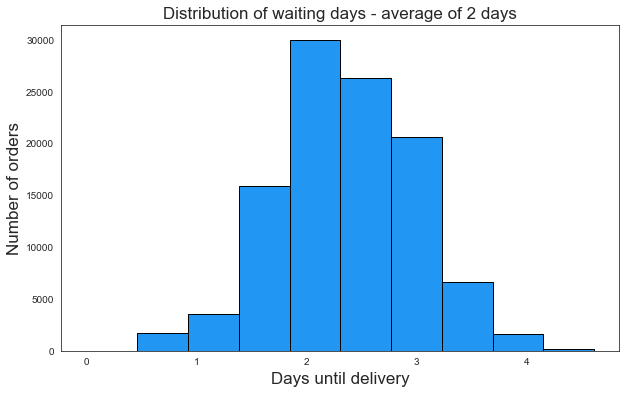

In [75]:
plt.figure(figsize=(10,6))

average_wait = data['wait_time'].mean()

plt.title(f'Distribution of waiting days - average of {round(average_wait)} days', fontsize=17)

plt.hist(data['wait_time'], ec='black', color='#2196f3')

plt.xlabel('Days until delivery', fontsize=17)
plt.ylabel('Number of orders', fontsize=17)

plt.show()

In [76]:
data['wait_time'].min()

0.0

In [77]:
data['wait_time'].max()

4.61512051684126

In [78]:
data.describe()

,distance,product_size_cm3,product_weight_g,wait_time
count,106510.000000,1.065100e+05,106510.000000,106510.000000
mean,597.574806,2.089629e+04,2839.308553,2.369565
std,592.482075,4.359839e+04,6705.522300,0.633756
min,0.000000,0.000000e+00,0.000000,0.000000
25%,182.069511,3.136000e+03,335.000000,1.945910
50%,432.239430,8.000000e+03,820.000000,2.397895
75%,792.611309,2.199900e+04,2400.000000,2.772589
max,8736.947618,1.476000e+06,184400.000000,4.615121


### Correlation: is the degree to which things move together

### $$ \rho _{XY} = corr(X,Y) $$
### $$ -1.0 \leq \rho _{XY} \leq + 1.0 $$

### strenght - is important because it tells us how much correlation there actually is, what's the extent of the movement.
### direction - if there is an increase in x, does y goes up or does y tends to go down. The direction is important because it tells us if the moves are in the same or in the opposite direction. In other words, is the correlation positive or negative.
### multicollinearity - is when two or more predictors in a regression are highly related to one another (each of these do not provide unique and independent information to the regression).

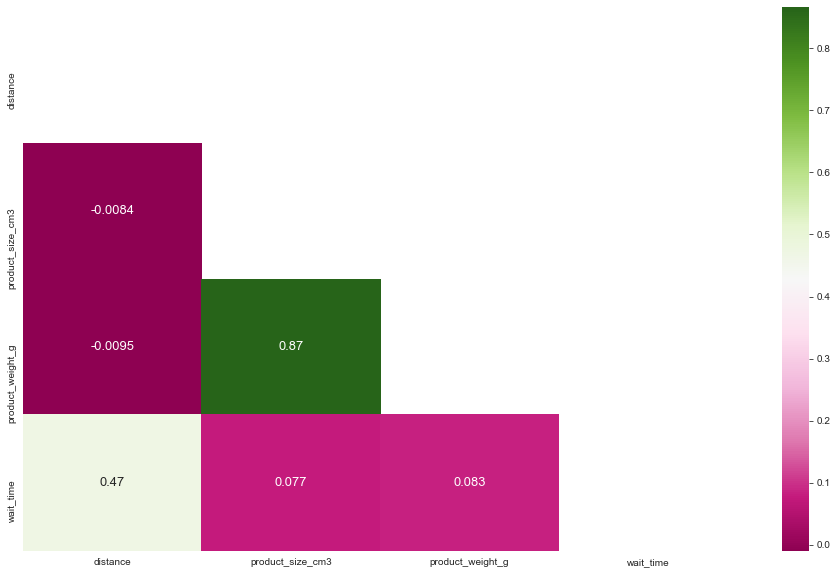

In [79]:
# All data correlations using Pearson Correlation Coefficients
#
mask = np.zeros_like(data.corr())
triangle_indices = np.triu_indices_from(mask) # up matrix diagonal indices
mask[triangle_indices] = True # set those indices to 1

plt.figure(figsize=(16,10))
sns.heatmap(data.corr(), cmap='PiYG', mask=mask, annot=True, annot_kws={"size" : 13})
sns.set_style('white')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# The only strong correlation is between product_size_cm3 and product_weight_g

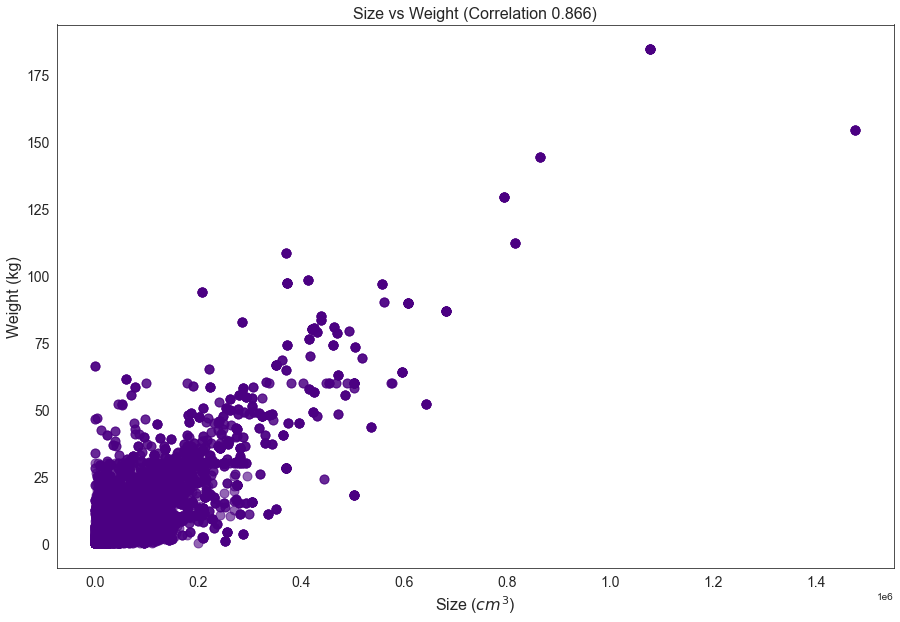

In [80]:
# Relationship between product_size_cm3 and product_weight_g
#
nox_dis_corr = round(data['product_size_cm3'].corr(data['product_weight_g']), 3)

plt.figure(figsize=[15, 10])

plt.title(f'Size vs Weight (Correlation {nox_dis_corr})', fontsize=16)
plt.xlabel('Size ($cm^3$)', fontsize=16)
plt.ylabel('Weight (kg)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(x=data['product_size_cm3'], y=data['product_weight_g']/1000, color='indigo', s=80, alpha=0.6)

plt.show()

In [81]:
data.loc[:, 'purchase_dayofweek'] = data.order_purchase_timestamp.dt.dayofweek

data.loc[:, 'year'] = data.order_purchase_timestamp.dt.year

data.loc[:, 'purchase_month'] = data.order_purchase_timestamp.dt.month

### Training & Dataset Split

In [82]:
X = data[['distance', 'geolocation_state_customer', 'geolocation_state_seller',
         'product_size_cm3', 'product_weight_g', 
          'purchase_dayofweek', 'year', 'purchase_month']]

y = data['wait_time']

X.head()

,distance,geolocation_state_customer,geolocation_state_seller,product_size_cm3,product_weight_g,purchase_dayofweek,year,purchase_month
0,18.063837,SP,SP,1976.0,500.0,0,2017,10
1,856.292580,BA,MG,4693.0,400.0,1,2018,7
2,514.130333,GO,SP,9576.0,420.0,2,2018,8
3,1822.800366,RN,MG,6000.0,450.0,5,2017,11
4,30.174037,SP,SP,11475.0,250.0,1,2018,2


In [83]:
# OneHot encoding
#
encode_features = ['geolocation_state_customer',
                   'geolocation_state_seller',
                  'year', 'purchase_month', 'purchase_dayofweek']

X = pd.get_dummies(X, columns = encode_features)

# scale numerical features
#
numerical_features = ['distance','product_size_cm3', 'product_weight_g']
scaler = MinMaxScaler()
X.loc[:, numerical_features] = scaler.fit_transform(X[numerical_features])

In [84]:
# The difference between estimated delivery time and actual delivery time
#
def directed_error(y_real, y_pred):
    return np.mean(abs(y_pred - y_real))

y_estimated_wait_days = (data['order_estimated_delivery_date'] - data['order_purchase_timestamp']).dt.days

y_real_wait_days = data['wait_time']

basic_score = directed_error(y_real_wait_days, y_estimated_wait_days)

basic_score

21.01428958575979

### Training & Test Dataset Split

In [85]:
# shuffle our data and then split it up
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Multivariable Regression

In [86]:
regr = LinearRegression()
regr.fit(x_train, y_train)

print('Intercept', regr.intercept_)
pd.DataFrame(data=regr.coef_, index=x_train.columns, columns=['coef'])

Intercept 2.022691299239582


,coef
distance,4.449202
product_size_cm3,0.425001
product_weight_g,1.060054
geolocation_state_customer_AC,-0.370779
geolocation_state_customer_AL,0.181169
...,...
purchase_dayofweek_2,-0.016967
purchase_dayofweek_3,0.038483
purchase_dayofweek_4,0.090675
purchase_dayofweek_5,0.051896


In [87]:
# R-squared for training and test datasets
# R-Squared is a statistical measure of fit that indicates how much variation 
# of a dependent variable is explained by the independent variable(s) in a regression model.
print('Training data r-squared:', regr.score(x_train, y_train))
print('Test data r-squared:', regr.score(x_test, y_test))

Training data r-squared: 0.3744681892795846
Test data r-squared: 0.37238042411722094


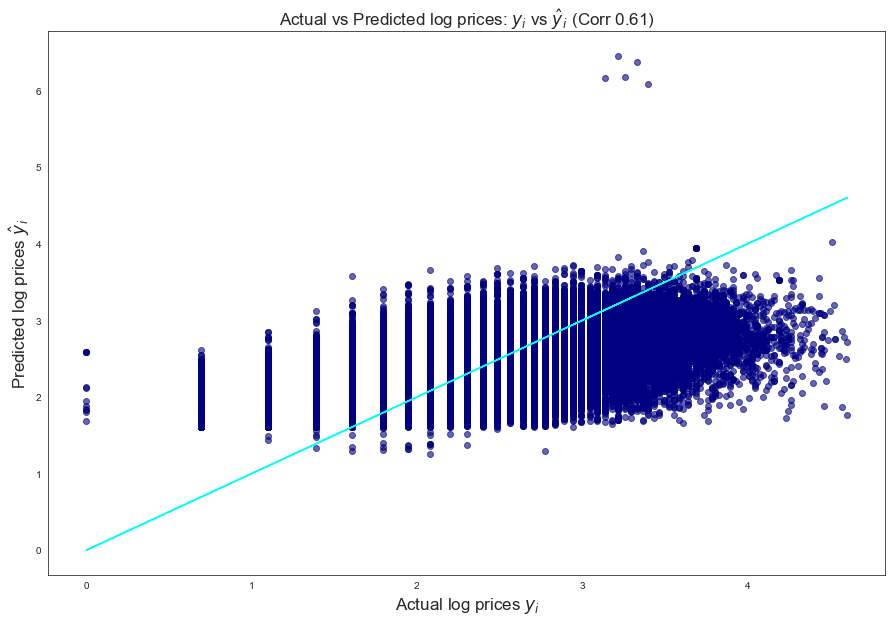

In [91]:
# Graph of Actual vs. Predicted Log Prices
plt.figure(figsize=[15, 10])
corr = round(y_train.corr(results.fittedvalues), 2)
plt.scatter(x=y_train, y=results.fittedvalues, color='navy', alpha=0.6)
plt.plot(y_train, y_train, color = 'cyan')

plt.xlabel('Actual log prices $y _i$', fontsize=17)
plt.ylabel('Predicted log prices $\hat y _i$', fontsize=17)
plt.title(f'Actual vs Predicted log prices: $y _i$ vs $\hat y_i$ (Corr {corr})', fontsize=17)

plt.show()

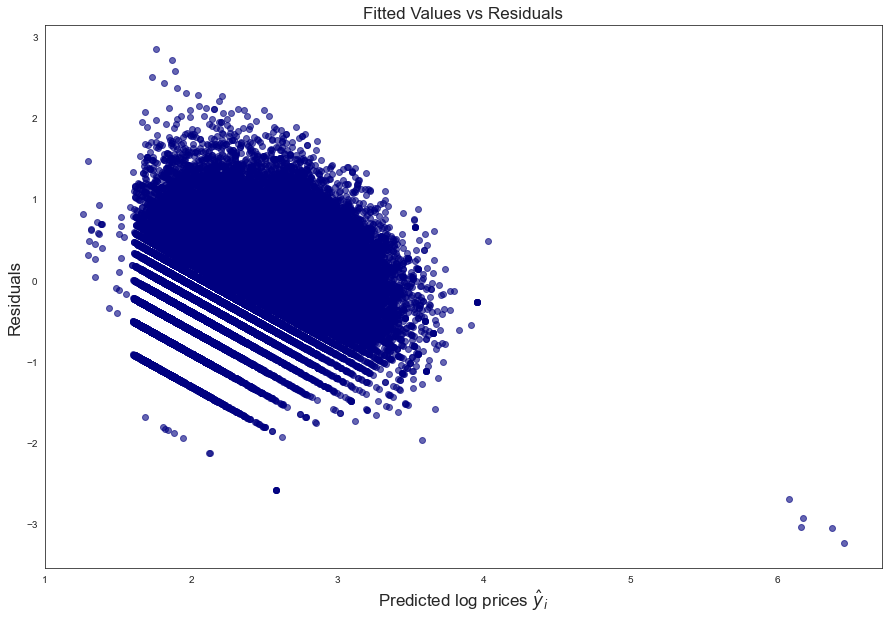

In [92]:
# Residuals vs Predicted values
plt.figure(figsize=[15, 10])
plt.scatter(x=results.fittedvalues, y=results.resid, color='navy', alpha=0.6)

plt.xlabel('Predicted log prices $\hat y _i$', fontsize=17)
plt.ylabel('Residuals', fontsize=17)
plt.title(f'Fitted Values vs Residuals', fontsize=17)

plt.show()

C:\Users\bueno\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


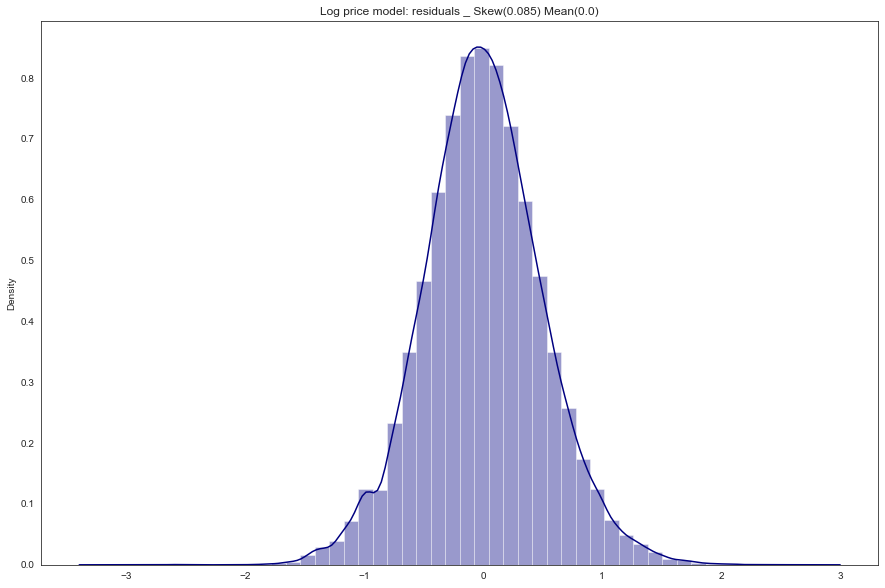

In [93]:
# Distribution of Residuals (log prices) - checking for normality
resid_mean = round(results.resid.mean(), 3)
resid_skew = round(results.resid.skew(), 3)

plt.figure(figsize=[15, 10])
sns.distplot(results.resid, color='navy')
plt.title(f'Log price model: residuals _ Skew({resid_skew}) Mean({resid_mean})')
plt.show()

# Mean Squared Error & R-Squared
reduced_log_mse = round(results.mse_resid, 3)
reduced_log_rsquared = round(results.rsquared, 3)